In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from analysis_toolbox.dataset_helper import open_ch0xml
import pathlib

def root_path():
    return os.path.abspath(os.sep)

def open_and_read_binary(filepath):
    
    f=open(filepath,"rb")
    file = f.read()
    arr = np.array(struct.unpack('d'*(len(file)//8), file))
    f.close()
    return arr   

In [3]:
def config_distributed_dats(dirs):

    log_types = ['backlog', 'runtime', 'stacks', 'planes', 'frames']

    from glob import glob

    logs = {}
    for dir in dirs:
        for log_type in log_types:

            if log_type == 'backlog': name = f'{os.path.splitdrive(dir)[0][0]} {log_type}'
            else: name = log_type

            if name not in logs:  ## do not overwrite
                logs[name] = {}

                if len(glob(dir + f'{log_type}.dat')) > 0:
                    logs[name]['path'] = glob(dir + f'{log_type}.dat')[0]

            if log_type == 'backlog':

                logs[name]['ch0'] = open_ch0xml(pathlib.Path(dir))    

    return logs 

def open_distributed_dats(dirs):

    logs = config_distributed_dats(dirs)

    import struct
    for ilog, log in logs.items():
        log['dat'] = open_and_read_binary(log['path'])    

    return logs

In [4]:
def print_logs_keys(logs):

    for ilog, log in logs.items():
        print(f'{ilog}: {log.keys()}')

def open_single_csv(dirs, csv_file):
    data = np.genfromtxt(csv_file, delimiter=',', names=True)
    logs = {}
    logs['runtime'] = {'dat': data['Elapsed_Time']}
    logs['D backlog'] = {'dat': data['Write_1']}
    logs['E backlog'] = {'dat': data['Write_2']}
    logs['frames'] = {'dat': data['Frames_completed']}

    for dir in dirs:
        drive = dir[0]
        logs[f'{drive} backlog']['ch0'] = open_ch0xml(pathlib.Path(dir))

    for i, backlog in enumerate(['D backlog', 'E backlog']): 
        start,stop = logs[backlog]['ch0'].loc['planes'].values[0].split(';')[i].split('-')
        logs[backlog]['numplanes'] = len(np.arange(int(start), int(stop)+1))    

    numplanes = np.mean((logs['D backlog']['numplanes'], logs['E backlog']['numplanes']))
    logs['planes'] = {'dat': logs['frames']['dat']/logs['runtime']['dat']}
    logs['stacks'] = {'dat': logs['planes']['dat'] / numplanes}

    return logs



In [5]:
dirs = ['D:\\jing\\20200808\\hs-single-plane_50ips_90fps_20200810_154441\\',
        'E:\\jing\\20200808\\hs-single-plane_50ips_90fps_20200810_154441\\']
csv_file = "C:\\Users\\ls2\\Desktop\\Backlog\\Backlog_hs-single-plane_50ips_90fps_20200810_154441.txt"

In [6]:
loggers = ['jing', 'andy']
logger = loggers[1]
print(f'Chosen logger: {logger}')

if logger == 'jing':
    logs = open_distributed_dats(dirs)
    savepath = os.path.abspath(dirs[0])

elif logger == 'andy':
    logs = open_single_csv(dirs, csv_file)
    savepath = os.path.abspath(dirs[0])

print_logs_keys(logs)

Chosen logger: andy
runtime: dict_keys(['dat'])
D backlog: dict_keys(['dat', 'ch0', 'numplanes'])
E backlog: dict_keys(['dat', 'ch0', 'numplanes'])
frames: dict_keys(['dat'])
planes: dict_keys(['dat'])
stacks: dict_keys(['dat'])


In [7]:
from analysis_toolbox.utils import calculate_image_size

for i, backlog in enumerate(['D backlog', 'E backlog']): 
    
    x_min, x_max, y_min, y_max = logs[backlog]['ch0'].loc['camera_roi'].to_string()[9:].split(';')[i].split('_')
    logs[backlog]['x_min'] = int(x_min)
    logs[backlog]['x_max'] = int(x_max)
    logs[backlog]['y_min'] = int(y_min)
    logs[backlog]['y_max'] = int(y_max)    
    logs[backlog]['numx'] = logs[backlog]['x_max'] - logs[backlog]['x_min']
    logs[backlog]['numy'] = logs[backlog]['y_max'] - logs[backlog]['y_min']
    logs[backlog]['numpix'] = logs[backlog]['numx'] * logs[backlog]['numy']
    logs[backlog]['imsize'] = calculate_image_size(logs[backlog]['numx'], logs[backlog]['numy'], 16)

for ilog, log in logs.items():
    print(f'{ilog}: {log.keys()}')

runtime: dict_keys(['dat'])
D backlog: dict_keys(['dat', 'ch0', 'numplanes', 'x_min', 'x_max', 'y_min', 'y_max', 'numx', 'numy', 'numpix', 'imsize'])
E backlog: dict_keys(['dat', 'ch0', 'numplanes', 'x_min', 'x_max', 'y_min', 'y_max', 'numx', 'numy', 'numpix', 'imsize'])
frames: dict_keys(['dat'])
planes: dict_keys(['dat'])
stacks: dict_keys(['dat'])


In [8]:
def fix_timeseries(timeseries, expt_start):

    fixed = np.full_like(timeseries, 0)
    fixed[expt_start:] = timeseries[expt_start:]

    return fixed

In [9]:
# Fix timeseries corrupted from values from previous experiment

from analysis_toolbox.math_helper import find_change

start_val = logs['runtime']['dat'][0]
if start_val != 0:

    min_val = np.nanmin(logs['runtime']['dat'])
    expt_start = np.where(find_change(logs['runtime']['dat'], start_val, min_val))[0][0]

    # replace original with fixed
    for log_type in log_types:
        if log_type != 'backlog':
            logs[log_type]['dat'] = fix_timeseries(logs[log_type]['dat'], expt_start)
    

(554,)
(554,)
(554,)
(554,)
(554,)
(554,)


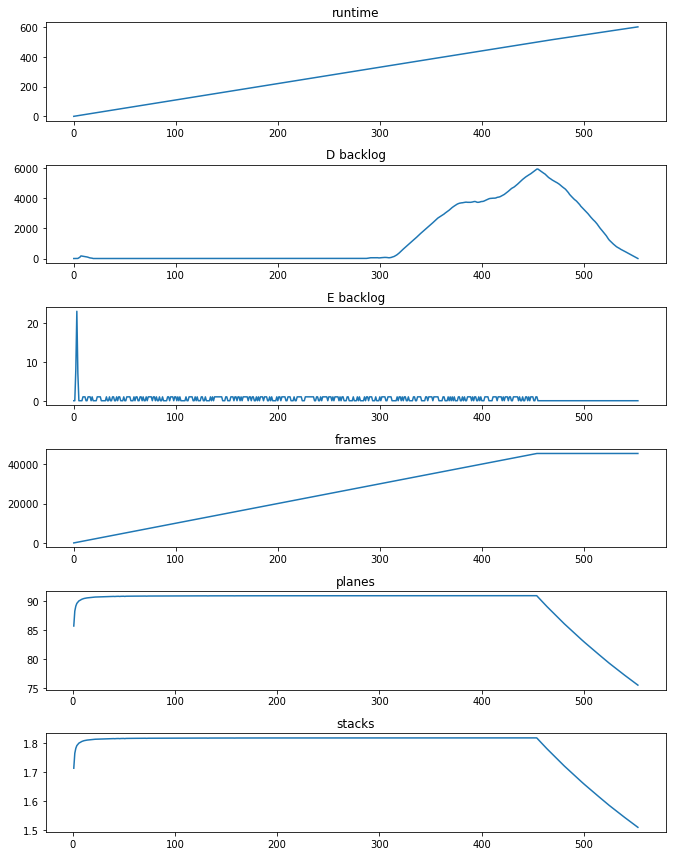

In [10]:
fig, ax = plt.subplots(len(logs), 1, figsize=(9.5, 2*len(logs)))

for i, (ilog, log) in enumerate(logs.items()):
    try: 
        print(log['dat'].shape)
        ax[i].plot(log['dat'])
        ax[i].set_title(ilog)
    except: 
        pass

fig.tight_layout()

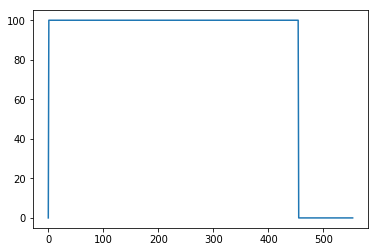

In [11]:
# find rate of input
logs['frames']['to_write'] = np.diff(np.insert(logs['frames']['dat'], 0, 0))

plt.figure()
plt.plot(logs['frames']['to_write'])

In [12]:
for i, backlog in enumerate(['D backlog', 'E backlog']):
    logs[backlog]['remainder'] = np.diff(np.insert(logs[backlog]['dat'], 0, 0))
    logs[backlog]['written'] = logs['frames']['to_write'] - logs[backlog]['remainder']
    logs[backlog]['written_size'] = logs[backlog]['written'] * logs[backlog]['imsize']


In [13]:
# find buffer over-run imminent
for i, backlog in enumerate(['D backlog', 'E backlog']):
    logs[backlog]['max'] = np.max(logs[backlog]['dat'])
    logs[backlog]['argmax'] = np.argmax(logs[backlog]['dat'])

max_backlog = np.max([logs[backlog]['max'] for i, backlog in enumerate(['D backlog', 'E backlog'])])
print(max_backlog)
overrun_bool = max_backlog > 5900
argmax_backlog = np.argmax([logs[backlog]['max'] for i, backlog in enumerate(['D backlog', 'E backlog'])])
overrun_drive = ['D backlog', 'E backlog'][argmax_backlog]
overrun_idx = logs[overrun_drive]['argmax']
overrun_time = logs['runtime']['dat'][overrun_idx]

if overrun_bool:
    print(f'{overrun_idx} {overrun_time:.2f}s')
    print(f'{overrun_drive} {max_backlog}')
else:
    print('buffer did not overrun!!')

5932.0
454 499.49s
D backlog 5932.0


(554,)
(554,)
(554,)
(554,)
(554,)


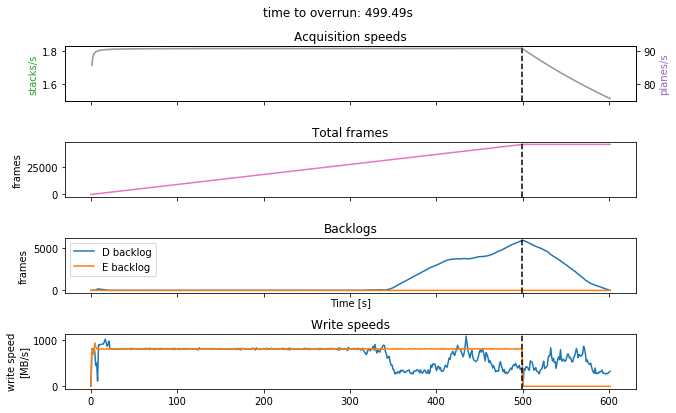

In [14]:
fig, ax = plt.subplots(4, 1, figsize=(9.5, 6), sharex=True)
ax0 = ax[0].twinx()
for i, (ilog, log) in enumerate(logs.items()):
    if ilog != 'runtime':
        print(log['dat'].shape)
        if 'backlog' in ilog:
            ax[2].plot(logs['runtime']['dat'], log['dat'], label=ilog)
        elif ilog == 'stacks':
            ax[0].plot(logs['runtime']['dat'], log['dat'], label=ilog, color='tab:green', alpha=0.5)
        elif ilog == 'planes':
            ax0.plot(logs['runtime']['dat'], log['dat'], label=ilog, color='tab:purple', alpha=0.5)
        elif ilog == 'frames':
            ax[1].plot(logs['runtime']['dat'], log['dat'], label=ilog, color='tab:pink')     

ax[3].plot(logs['runtime']['dat'], logs['D backlog']['written_size']/1024/1024, color='tab:blue', label='D')
ax[3].plot(logs['runtime']['dat'], logs['E backlog']['written_size']/1024/1024, color='tab:orange', label='E')

ax[2].set_title('Backlogs')
ax[0].set_title('Acquisition speeds')
ax[1].set_title('Total frames')
ax[3].set_title('Write speeds')

ax[2].legend()

ax[2].set_ylabel('frames')
ax[0].set_ylabel('stacks/s', color='tab:green')
ax0.set_ylabel('planes/s', color='tab:purple')
ax[1].set_ylabel('frames')
ax[3].set_ylabel('write speed\n[MB/s]')

ax[2].set_xlabel('Time [s]')

if overrun_bool:
    for ax_ in ax:
        ax_.axvline(x=overrun_time, color='k', linestyle='--')

    fig.suptitle(f'time to overrun: {overrun_time:.2f}s')
else:
    fig.suptitle(f'buffer did not overrun!!')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [15]:
from analysis_toolbox.utils import now_str
fig.savefig(savepath + f'\performance_{now_str()}.png')